In [1]:
import pandas as pd
import numpy as np
from scipy import stats 
import os
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import datetime
import random

In [2]:
file_cust = pd.read_csv('ecommerce_data/olist_customers_dataset.csv')
file_geo = pd.read_csv('ecommerce_data/olist_geolocation_dataset.csv')
file_items = pd.read_csv('ecommerce_data/olist_order_items_dataset.csv')
file_payments = pd.read_csv('ecommerce_data/olist_order_payments_dataset.csv')
file_reviews = pd.read_csv('ecommerce_data/olist_order_reviews_dataset.csv')
file_orders = pd.read_csv('ecommerce_data/olist_orders_dataset.csv')
file_products = pd.read_csv('ecommerce_data/olist_products_dataset.csv')
file_sellers = pd.read_csv('ecommerce_data/olist_sellers_dataset.csv')
file_category = pd.read_csv('ecommerce_data/product_category_name_translation.csv')

In [3]:
file_cust = file_cust.dropna()
file_geo = file_geo.dropna()
file_items = file_items.dropna()
file_payments = file_payments.dropna()
file_reviews = file_reviews.dropna()
file_orders = file_orders.dropna()
file_products = file_products.dropna()
file_sellers = file_sellers.dropna()
file_category = file_category.dropna()

In [4]:
data = file_orders.merge(file_items, on='order_id',how='left')
data = data.merge(file_payments, on='order_id',how='outer',validate='m:m')
data = data.merge(file_reviews, on='order_id',how='outer')
data = data.merge(file_products,on='product_id',how='outer')
data = data.merge(file_cust,on='customer_id',how='outer')
data = data.merge(file_sellers, on='seller_id',how='outer')
data = data.merge(file_category, on='product_category_name',how='outer')

In [5]:
#data = data.dropna()

In [6]:
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'product_category_name_english'],
      dtype='object')

In [7]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['order_approved_at'] = pd.to_datetime(data['order_approved_at'])
data['order_delivered_carrier_date'] = pd.to_datetime(data['order_delivered_carrier_date'])
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])
data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date'])
data['shipping_limit_date'] = pd.to_datetime(data['shipping_limit_date'])
data['review_creation_date'] = pd.to_datetime(data['review_creation_date'])
data['review_answer_timestamp'] = pd.to_datetime(data['review_answer_timestamp'])

In [8]:
#order_dates, order_times = zip(*[(d.date(), d.time()) for d in data['order_purchase_timestamp']])
#data = data.assign(order_date=order_dates, order_time=order_times)

In [9]:
unique_orders = data.drop_duplicates(subset='order_id')
unique_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149.0,sao paulo,SP,9350.0,maua,SP,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366.0,sao paulo,SP,9350.0,maua,SP,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290.0,sao paulo,SP,9350.0,maua,SP,housewares
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,e781fdcc107d13d865fc7698711cc572,88032.0,florianopolis,SC,9350.0,maua,SP,housewares
6,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24 11:31:28,2017-08-24 11:45:25,2017-08-25 14:17:55,2017-08-28 20:12:20,2017-09-14,2.0,be03d93320192443b8fa24c0ca6ead98,...,16.0,13.0,7a1de9bde89aedca8c5fbad489c5571c,1315.0,sao paulo,SP,9350.0,maua,SP,housewares
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121994,872b07190c0c9c0f13475d2141c4036a,814605f2161337c56520639099b0199f,delivered,2018-07-03 10:10:12,2018-07-05 16:22:38,2018-07-03 12:00:00,2018-07-10 17:18:49,2018-08-02,1.0,019003324f0a201dd2c8962beaf94b6d,...,2.0,23.0,c5df80808db02b2e08abd92b9d964b9b,66033.0,belem,PA,5201.0,sao paulo,SP,books_imported
121996,522eec5aa38ae3153b1c1a94e013947e,39eda8beee70b851aa9ba9040fb44615,delivered,2018-07-05 16:25:40,2018-07-06 02:35:18,2018-07-06 10:27:00,2018-07-09 18:16:53,2018-07-27,1.0,5b668636d65ddf4e4109c6d8fb13ea56,...,2.0,30.0,9790c90c5b3a1a5237c11433331af1cb,83206.0,paranagua,PR,5201.0,sao paulo,SP,books_imported
121997,1dbff949801376b8795a093d31cfe205,0cbd2df3d6e9d8b1eaf5cfefc44886bc,delivered,2018-05-16 14:50:54,2018-05-16 15:18:42,2018-05-18 12:10:00,2018-05-21 17:14:08,2018-05-28,1.0,90797f195eb7bb9dae050697a25f35ce,...,2.0,23.0,1de8fb735d8252498d9a2f82a68c57e0,9411.0,ribeirao pires,SP,5201.0,sao paulo,SP,books_imported
121998,6775b950cdc4da0ce39b261032f92c84,c4d135422be0d4333f506acde8af9419,delivered,2018-06-13 12:19:26,2018-06-13 17:39:14,2018-06-15 13:09:00,2018-06-16 17:48:30,2018-06-28,1.0,3e72533d34a1779d818ac8a73403387c,...,2.0,23.0,5f684afb3d1a02f2787e80cb0eee6e02,2927.0,sao paulo,SP,5201.0,sao paulo,SP,books_imported


In [10]:
data['customer_unique_id'].nunique()

96096

In [11]:
df = unique_orders['customer_unique_id'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [12]:
df

,unique_values,counts
0,8d50f5eadf50201ccdcedfb9e2ac8455,15
1,3e43e6105506432c953e165fb2acf44c,9
2,1b6c7548a2a1f9037c1fd3ddfed95f33,7
3,ca77025e7201e3b30c44b472ff346268,7
4,6469f99c1f9dfae7733b25662e7f1782,7
...,...,...
93337,bcb745c59d24efb6a0da4d264a596996,1
93338,833595cb77d684c9a0ebd1d1476026f8,1
93339,575605c52d041c777fd46210b3e30272,1
93340,912d43df8dc8e521c94fcdd4c94f5879,1


In [13]:
df1 = df.loc[df['counts'] > 1]

In [14]:
df1['counts'].sum()

5919

In [15]:
repeat_list = df1['unique_values'].tolist()

In [16]:
len(repeat_list)

2800

In [17]:
len(data['customer_unique_id'].unique())

96097

In [18]:
data["repeat?"] = np.where(data["customer_unique_id"].isin(repeat_list), 1, 0)

In [19]:
data['repeat?'].value_counts()

0    114319
1      7682
Name: repeat?, dtype: int64

In [20]:
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'product_category_name_english', 'repeat?'],
      dtype='object')

In [21]:
data['delivery_time b/(w)'] = data['order_estimated_delivery_date'] - data['order_delivered_customer_date']
data['delivery_days b/(w)'] = data['delivery_time b/(w)'].apply(lambda x: x.days)

In [22]:
def is_late_func(x):
    if x>-1:
        return 1
    if x<0:
        return 0
    
data['late'] = data['delivery_days b/(w)'].apply(is_late_func)

In [23]:
data['review_answer_time'] = data['review_answer_timestamp'] - data['review_creation_date']
data['review_response_days'] = data['review_answer_time'].apply(lambda x: x.days)

In [24]:
data['freight_percent'] = data['freight_value'] / data['payment_value']

In [25]:
first_order_df = data.sort_values(by='order_purchase_timestamp')
first_order_df = first_order_df.loc[first_order_df['order_purchase_timestamp']!=0]
first_order_df.drop_duplicates(subset ="customer_unique_id",keep = 'first', inplace = True)
#first_order_df.drop_duplicates(subset ="customer_id",keep = 'first', inplace = True)

In [26]:
first_order_df['repeat?'].value_counts()

0    93297
1     2800
Name: repeat?, dtype: int64

In [27]:
df_clean = first_order_df[['freight_value','payment_installments','payment_value','review_score','delivery_days b/(w)','review_response_days','freight_percent','late','repeat?']].copy()

In [28]:
df_clean = df_clean.dropna()
df_clean

,freight_value,payment_installments,payment_value,review_score,delivery_days b/(w),review_response_days,freight_percent,late,repeat?
66391,24.89,1.0,123.89,5.0,22.0,383.0,0.200904,1.0,0
16987,16.12,2.0,86.02,5.0,7.0,411.0,0.187398,1.0,0
104800,17.86,6.0,317.85,1.0,13.0,238.0,0.056190,1.0,0
17756,16.09,2.0,158.09,1.0,10.0,310.0,0.101777,1.0,0
20766,11.95,1.0,76.95,5.0,13.0,348.0,0.155296,1.0,0
...,...,...,...,...,...,...,...,...,...
47760,9.21,1.0,74.21,5.0,3.0,3.0,0.124107,1.0,0
60369,7.95,1.0,106.95,1.0,4.0,3.0,0.074334,1.0,0
20211,7.39,1.0,14.29,5.0,4.0,2.0,0.517145,1.0,0
26410,9.20,7.0,73.10,1.0,3.0,21.0,0.125855,1.0,0


In [29]:
print(df_clean.dtypes)

freight_value           float64
payment_installments    float64
payment_value           float64
review_score            float64
delivery_days b/(w)     float64
review_response_days    float64
freight_percent         float64
late                    float64
repeat?                   int64
dtype: object


In [30]:
df_clean['payment_installments'] = df_clean['payment_installments'].astype('int')
df_clean['review_score'] = df_clean['review_score'].astype('int')
df_clean['delivery_days b/(w)'] = df_clean['delivery_days b/(w)'].astype('int')
df_clean['review_response_days'] = df_clean['review_response_days'].astype('int')
df_clean['late'] = df_clean['late'].astype('int')

In [31]:
print(df_clean.dtypes)

freight_value           float64
payment_installments      int64
payment_value           float64
review_score              int64
delivery_days b/(w)       int64
review_response_days      int64
freight_percent         float64
late                      int64
repeat?                   int64
dtype: object


In [32]:
repeat_df = df_clean.loc[df_clean['repeat?'] == 1]

In [33]:
repeat_df

,freight_value,payment_installments,payment_value,review_score,delivery_days b/(w),review_response_days,freight_percent,late,repeat?
60171,7.78,1,42.78,5,14,159,0.181861,1,1
86186,17.60,1,67.50,1,-7,204,0.260741,0,1
90153,30.82,3,170.76,4,0,3,0.180487,1,1
90048,57.08,2,348.14,1,-22,7,0.163957,0,1
120394,35.69,6,115.59,1,-48,0,0.308764,0,1
...,...,...,...,...,...,...,...,...,...
110166,4.49,1,86.04,3,10,3,0.052185,1,1
19455,7.52,1,44.45,5,-1,0,0.169179,0,1
121822,91.32,5,250.32,4,8,0,0.364813,1,1
9614,50.89,7,220.00,5,5,2,0.231318,1,1


In [34]:
non_repeat_df = df_clean.loc[df_clean['repeat?'] == 0]

In [57]:
non_repeat_df = non_repeat_df.iloc[:141]

In [58]:
even_df = pd.concat([repeat_df,non_repeat_df])

In [59]:
even_df

,freight_value,payment_installments,payment_value,review_score,delivery_days b/(w),review_response_days,freight_percent,late,repeat?
60171,7.78,1,42.78,5,14,159,0.181861,1,1
86186,17.60,1,67.50,1,-7,204,0.260741,0,1
90153,30.82,3,170.76,4,0,3,0.180487,1,1
90048,57.08,2,348.14,1,-22,7,0.163957,0,1
120394,35.69,6,115.59,1,-48,0,0.308764,0,1
...,...,...,...,...,...,...,...,...,...
41000,70.83,6,190.83,4,-5,2,0.371168,0,0
12721,58.58,8,228.57,1,-5,0,0.256289,0,0
98874,25.23,6,175.13,1,-11,6,0.144064,0,0
65448,45.46,1,175.36,1,-10,4,0.259238,0,0


In [60]:
#df_clean = df_clean.dropna()

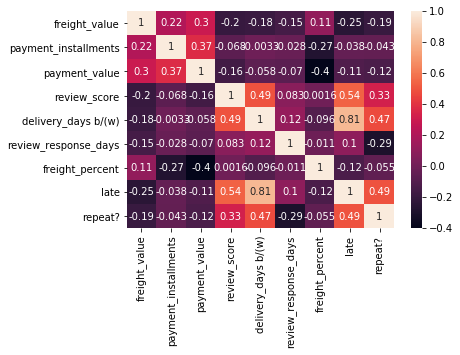

In [61]:
corrMatrix = even_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [62]:
corr_df = even_df.corr()

In [63]:
sorted_corr_df = corr_df.sort_values(by='repeat?',ascending=False)

In [64]:
sorted_corr_df

,freight_value,payment_installments,payment_value,review_score,delivery_days b/(w),review_response_days,freight_percent,late,repeat?
repeat?,-0.190959,-0.042673,-0.123323,0.330497,0.473150,-0.294299,-0.054839,0.493033,1.000000
late,-0.246486,-0.038093,-0.110421,0.538661,0.812455,0.101655,-0.124557,1.000000,0.493033
delivery_days b/(w),-0.184951,-0.003316,-0.058368,0.491485,1.000000,0.120964,-0.095786,0.812455,0.473150
review_score,-0.199087,-0.067908,-0.158963,1.000000,0.491485,0.082739,0.001644,0.538661,0.330497
payment_installments,0.215926,1.000000,0.374995,-0.067908,-0.003316,-0.027835,-0.272705,-0.038093,-0.042673
freight_percent,0.111442,-0.272705,-0.402222,0.001644,-0.095786,-0.011092,1.000000,-0.124557,-0.054839
payment_value,0.295242,0.374995,1.000000,-0.158963,-0.058368,-0.070222,-0.402222,-0.110421,-0.123323
freight_value,1.000000,0.215926,0.295242,-0.199087,-0.184951,-0.147462,0.111442,-0.246486,-0.190959
review_response_days,-0.147462,-0.027835,-0.070222,0.082739,0.120964,1.000000,-0.011092,0.101655,-0.294299


In [65]:
df_clean = df_clean.dropna()

In [78]:
X = even_df[['review_response_days','delivery_days b/(w)','late','review_score']].values
y = even_df['repeat?'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
logisticModel = LogisticRegression()
#training data with logistic regression model
logisticModel.fit(X,y)

#X_test = df_clean[['review_response_days','delivery_days b/(w)','late','review_score']].values
#y_test = df_clean['repeat?'].values
#predicting with models
predicts = logisticModel.predict(X_test)
print(predicts)

[1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0
 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1]


In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predicts))
print("Accuracy:", accuracy_score(y_test, predicts))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.82      0.88      0.85        26

    accuracy                           0.86        57
   macro avg       0.86      0.86      0.86        57
weighted avg       0.86      0.86      0.86        57

Accuracy: 0.8596491228070176
